In [138]:
# Import necessary packages

import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import shap
from matplotlib.ticker import FormatStrFormatter

In [63]:
def rand_seed_split(X, y, minmax_ftrs, std_ftrs, num_states, p = None):

    if p is not None:
        # Getting only p percent of the examples for computation time
        X, _, y, _ = train_test_split(X, y, test_size=1 - p, stratify=y, random_state=10)
    
    nr_states = num_states

    # feature arrays
    train_sets = []
    val_sets = []
    test_sets = []

    # target variables
    train_tar = []
    val_tar = []
    test_tar = []
    
    # loop through the different random states
    for i in range(nr_states):
        print('random state '+str(i+1))
    
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=i)

        # Set up preprocessor
        minmax_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)),  
            ('scaler', MinMaxScaler())                   
        ])
        
        std_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)), 
            ('scaler', StandardScaler())                  
        ])
        
        prep_iter = ColumnTransformer(
            transformers=[
                ('minmax', minmax_pipeline, minmax_ftrs),
                ('std', std_pipeline, std_ftrs)          
            ],
            remainder='passthrough' 
        )

        
        # preprocess the sets
        X_train_prep = prep_iter.fit_transform(X_train)
        X_val_prep = prep_iter.transform(X_val)
        X_test_prep = prep_iter.transform(X_test)

        feature_names = prep_iter.get_feature_names_out()

    #     train_sets.append(X_train_prep)
    #     val_sets.append(X_val_prep)
    #     test_sets.append(X_test_prep)

    #     train_tar.append(y_train)
    #     val_tar.append(y_val)
    #     test_tar.append(y_test)

    # X_sets = [train_sets, val_sets, test_sets]
    # y_sets = [train_tar, val_tar, test_tar]

    # # save the rand seed X arrays
    # with open('rand_seeds_X_list.pkl', 'wb') as file:
    #     pickle.dump(X_sets, file)

    # # save the rand seed y series
    # with open('rand_seeds_y_list.pkl', 'wb') as file:
    #     pickle.dump(y_sets, file)
        
    # return X_sets, y_sets

    return feature_names

In [10]:
# Read in csv
df = pd.read_csv('data/A3266_00-1111_all.csv')
df = df.drop('idn', axis=1) #Drop index column

#Some rows have inf values in them. Replace inf with nan 
df = df.replace([np.inf, -np.inf], np.nan)

# No Y mag data available for this cluster. Dropping four columns.
df = df.drop(['Y_psf_mag', 'Y_psf_magerr', 'Y_cmodel_mag', 'Y_cmodel_magerr',], axis=1)

# Feature engineering
u_diff = df['u_psf_mag'] - df['u_cmodel_mag']
g_diff = df['g_psf_mag'] - df['g_cmodel_mag']
r_diff = df['r_psf_mag'] - df['r_cmodel_mag']
i_diff = df['i_psf_mag'] - df['i_cmodel_mag']
z_diff = df['z_psf_mag'] - df['z_cmodel_mag']

df["u_mag_diff"] = u_diff; df["g_mag_diff"] = g_diff; df["r_mag_diff"] = r_diff
df["i_mag_diff"] = i_diff; df["z_mag_diff"] = z_diff 

# Split target from feature matrix
y = df['extendedness']
X = df.loc[:, df.columns != 'extendedness']

In [13]:
minmax_ftrs = ['ra','dec','x','y','e1','e2','res','blendedness','e1_sdss','e2_sdss','e1_psf_sdss','e2_psf_sdss', \
              'e1_hsm','e2_hsm','e1_psf_hsm','e2_psf_hsm','i_e1_psf_sdss','i_e2_psf_sdss']
std_ftrs = ['sigmae','rkron','u_psf_mag','u_psf_magerr','u_cmodel_mag','u_cmodel_magerr', \
           'g_psf_mag','g_psf_magerr','g_cmodel_mag','g_cmodel_magerr', \
           'r_psf_mag','r_psf_magerr','r_cmodel_mag','r_cmodel_magerr', \
           'i_psf_mag','i_psf_magerr','i_cmodel_mag','i_cmodel_magerr', \
           'z_psf_mag','z_psf_magerr','z_cmodel_mag','z_cmodel_magerr', \
           'u_mag_diff','g_mag_diff','r_mag_diff','i_mag_diff','z_mag_diff']

X_sets, y_sets = rand_seed_split(X, y, minmax_ftrs, std_ftrs, num_states = 5, p = None)

random state 1
random state 2
random state 3
random state 4
random state 5


In [23]:
# BASELINE SCORE

maj_balances = []

for df in y_sets[2]:
    maj_balances.append(df.value_counts()[1] / df.shape[0])

# print(maj_balances)
print(f'Average Baseline Score: {np.mean(maj_balances)}')
print(f'Stan. Dev. Baseline Score: {np.std(maj_balances)}')


Average Baseline Score: 0.7643707087046512
Stan. Dev. Baseline Score: 0.0


In [25]:
# Log Reg Results

# Load pipeline
with open('logreg_models_list.pkl', 'rb') as file:
    logreg_models = pickle.load(file)

# Evaluate the model
# for df in X_sets[2]:
#     logreg_accuracies = logreg_models.score(df, y_test)
#     print("Accuracy:", logreg_accuracies)

logreg_accs = []
for model, df_X, df_y in zip(logreg_models, X_sets[2], y_sets[2]):
    logreg_accs.append(model.score(df_X, df_y))
    print("Accuracy:", model.score(df_X, df_y))
print("Mean Accuracy:", np.mean(logreg_accs))
print("Standard Deviation:", np.std(logreg_accs))


Accuracy: 0.8005259233939015
Accuracy: 0.8056855710198446
Accuracy: 0.7739740591112056
Accuracy: 0.8006981808002972
Accuracy: 0.800232547498634
Mean Accuracy: 0.7962232563647765
Standard Deviation: 0.011306409551426923


In [27]:
# SVC Results

# Load pipeline
with open('svc_models_list.pkl', 'rb') as file:
    svc_models = pickle.load(file)

svc_accs = []
for model, df_X, df_y in zip(svc_models, X_sets[2], y_sets[2]):
    svc_accs.append(model.score(df_X, df_y))
    print("Accuracy:", model.score(df_X, df_y))
print("Mean Accuracy:", np.mean(svc_accs))
print("Standard Deviation:", np.std(svc_accs))


Accuracy: 0.9179758678139728
Accuracy: 0.7488029456016494
Accuracy: 0.9455881917547916
Accuracy: 0.7924675066009577
Accuracy: 0.7274161119888464
Mean Accuracy: 0.8264501247520435
Standard Deviation: 0.08895221088043465


In [29]:
# knn Results

# Load pipeline
with open('knn_models_list.pkl', 'rb') as file:
    knn_models = pickle.load(file)

knn_accs = []
for model, df_X, df_y in zip(knn_models, X_sets[2], y_sets[2]):
    knn_accs.append(model.score(df_X, df_y))
    print("Accuracy:", model.score(df_X, df_y))
print("Mean Accuracy:", np.mean(knn_accs))
print("Standard Deviation:", np.std(knn_accs))


Accuracy: 0.874133666364319
Accuracy: 0.8510700145611338
Accuracy: 0.861034028912329
Accuracy: 0.8631980125801737
Accuracy: 0.8373594016208346
Mean Accuracy: 0.857359024807758
Standard Deviation: 0.012397778915815581


In [30]:
# Random Forest Results

# Load pipeline
with open('rf_models_list.pkl', 'rb') as file:
    rf_models = pickle.load(file)

rf_accs = []
for model, df_X, df_y in zip(rf_models, X_sets[2], y_sets[2]):
    rf_accs.append(model.score(df_X, df_y))
    print("Accuracy:", model.score(df_X, df_y))
print("Mean Accuracy:", np.mean(rf_accs))
print("Standard Deviation:", np.std(rf_accs))


Accuracy: 0.9005671036801179
Accuracy: 0.7585085738432511
Accuracy: 0.9475879925821654
Accuracy: 0.7832625014466931
Accuracy: 0.7303014235459725
Mean Accuracy: 0.82404551901964
Standard Deviation: 0.08469308925110994


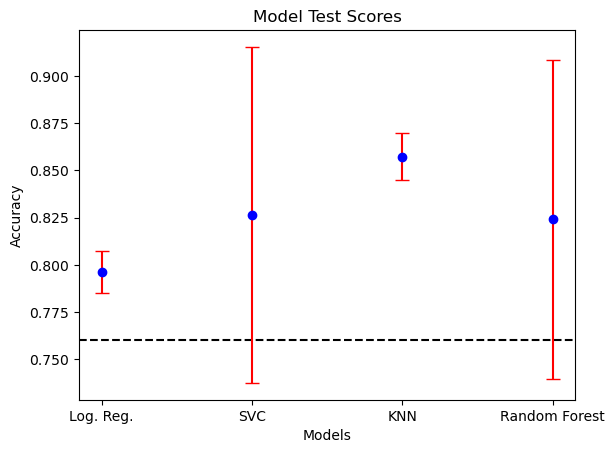

In [37]:
# Plotting means and Stand. Devs.

plt.axhline(y=0.76, color='k', linestyle='--', label='Baseline Accuracy')
plt.errorbar('Log. Reg.', np.mean(logreg_accs), yerr=np.std(logreg_accs), fmt='o', label='Logistics Regression', color='b', ecolor='r', capsize=5)
plt.errorbar('SVC', np.mean(svc_accs), yerr=np.std(svc_accs), fmt='o', label='SVC', color='b', ecolor='r', capsize=5)
plt.errorbar('KNN', np.mean(knn_accs), yerr=np.std(knn_accs), fmt='o', label='KNN', color='b', ecolor='r', capsize=5)
plt.errorbar('Random Forest', np.mean(rf_accs), yerr=np.std(rf_accs), fmt='o', label='Random Forest', color='b', ecolor='r', capsize=5)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Test Scores')
# plt.legend()

# plt.savefig('model_accs.png', dpi=300, bbox_inches='tight')

plt.show()

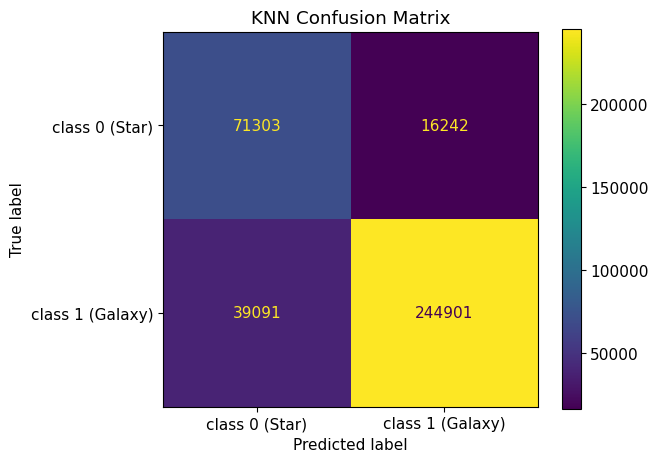

Accuracy: 0.8511
Precision: 0.9378
Recall: 0.8624
FPR: 0.1855


In [73]:
# Best model: KNN Classifier

# Confusion matrix
cm = confusion_matrix(y_sets[2][1],knn_models[1].predict(X_sets[2][1]))

disp = ConfusionMatrixDisplay(cm,display_labels=['class 0 (Star)', 'class 1 (Galaxy)'])
disp.plot(cmap='viridis')
plt.title(f'KNN Confusion Matrix')
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
# disp_25.plot(ax=ax1); disp_50.plot(ax=ax2); disp_75.plot(ax=ax3)
# ax1.set_title('p_crit = 0.25'); ax2.set_title('p_crit = 0.5'); ax3.set_title('p_crit = 0.75')
plt.tight_layout()
# plt.savefig('knn_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
FPR = FP/(FP+TN)

print(f'Accuracy: {(TP + TN)/(TP + FP + FN + TN):.4f}')
print(f'Precision: {TP/(TP + FP):.4f}')
print(f'Recall: {TP/(TP + FN):.4f}')
print(f'FPR: {FPR:.4f}')

random state 1


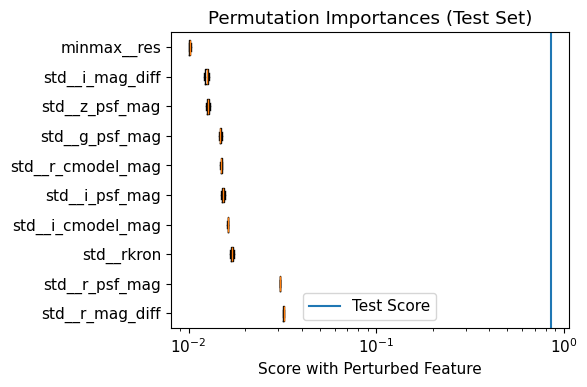

In [70]:
# Global Feature Importance

# Permutation
perm_imp = permutation_importance(estimator= knn_models[1], X=X_sets[2][1], y=y_sets[2][1], n_repeats=2,
                                  random_state=0, scoring='accuracy')

perm_means = perm_imp.importances_mean 
perm_std = perm_imp.importances_mean
perm_importances = perm_imp.importances 
feature_names = rand_seed_split(X, y, minmax_ftrs, std_ftrs, num_states = 1, p = 0.1)

# Get indices of sorted array
# [::-1] sorts in descending order
sorted_indcs = np.argsort(perm_means)[::-1]

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(6,4))
plt.boxplot(perm_importances[sorted_indcs][:10].T,
            tick_labels=feature_names[sorted_indcs][:10],vert=False)
plt.xscale('log')
plt.axvline(accuracy_score(y_sets[2][1],knn_models[1].predict(X_sets[2][1])),label='Test Score')
plt.title("Permutation Importances (Test Set)")
plt.xlabel('Score with Perturbed Feature')
plt.legend()
plt.tight_layout()
plt.savefig('global_imporatance.png', dpi=300, bbox_inches='tight')
plt.show()


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


explainer created


  0%|          | 0/200 [00:00<?, ?it/s]

(200, 46)


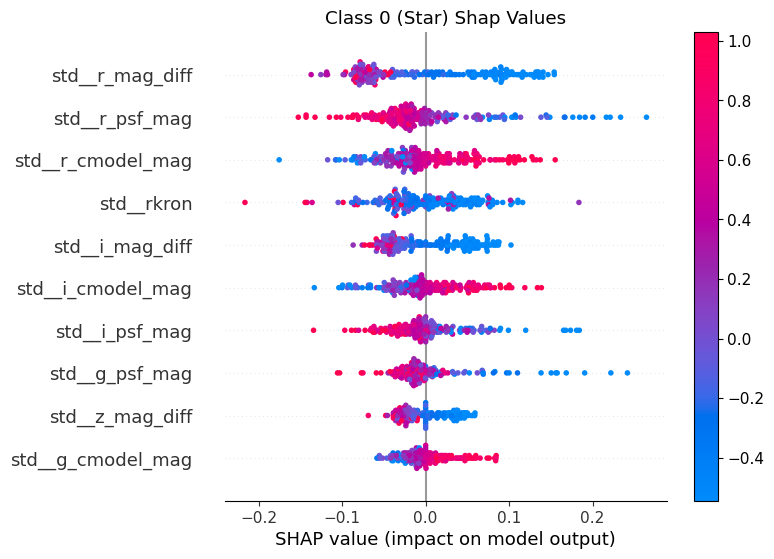

In [137]:
shap.initjs() # required for visualizations later on

# predictions = knn_models[1].predict_proba(X_sets[2][1][:1])

temp_df = pd.DataFrame(X_sets[2][1][:200], columns=feature_names)
# temp_df_filtered = temp_df[temp_df.columns[~temp_df.columns.str.endswith('magerr')]]
# print(temp_df_filtered)
# print(temp_df)
# # create the explainer object
explainer = shap.KernelExplainer(knn_models[1].predict_proba, temp_df,nsamples=50, seed=0)
print('explainer created')
# # X_sets[2][1][:1]
# # # These shap_values return array (n_samples, n_features, n_classes). Local feature importance
shap_values = explainer.shap_values(temp_df)
print(shap_values[:,:,0].shape)
# X_sets[2][1]
# # Finding global feature importance 
# # Plots are now named more directly, so summary_plot (default) becomes beeswarm
shap.summary_plot(shap_values[:,:,0], temp_df, feature_names = feature_names, max_display=10, show=False, color_bar=False)
plt.colorbar()
                  # , show=False)
plt.title('Class 0 (Star) Shap Values')
# plt.savefig('shap_global.png', dpi=300, bbox_inches='tight')
# # shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], show=False, matplotlib=True).savefig('scratch.png')
# # shap.save_html(f'../figures/{filename_here}.html', shap_output)

In [155]:
# Local feature importances

shap_values_truncated = np.round(shap_values, 2)
temp_df_truncated = np.round(temp_df, 2)
print(shap_values_truncated.shape)
print(explainer.expected_value[1])
print(feature_names)

feat_names_trunc = [name.split('__')[-1] for name in feature_names]

print(feat_names_trunc)

for ind in [0, 99]:
    shap.force_plot(explainer.expected_value[1], shap_values_truncated[ind,:,1], 
                    features = temp_df_truncated.iloc[[ind]],feature_names = feat_names_trunc,
                    show=False, matplotlib=True).savefig(f'shap_local_{ind}.png', dpi=300, bbox_inches='tight')
    # shap.force_plot(explainer.expected_value[1], shap_values_truncated[ind,:,1], X.iloc[0,:], show=False, matplotlib=True).savefig('scratch.png')
    # plt.savefig(f'shap_local_{ind}.png', dpi=300, bbox_inches='tight')
    

(200, 46, 2)
0.7514999999999996
['minmax__ra' 'minmax__dec' 'minmax__x' 'minmax__y' 'minmax__e1'
 'minmax__e2' 'minmax__res' 'minmax__blendedness' 'minmax__e1_sdss'
 'minmax__e2_sdss' 'minmax__e1_psf_sdss' 'minmax__e2_psf_sdss'
 'minmax__e1_hsm' 'minmax__e2_hsm' 'minmax__e1_psf_hsm'
 'minmax__e2_psf_hsm' 'minmax__i_e1_psf_sdss' 'minmax__i_e2_psf_sdss'
 'std__sigmae' 'std__rkron' 'std__u_psf_mag' 'std__u_psf_magerr'
 'std__u_cmodel_mag' 'std__u_cmodel_magerr' 'std__g_psf_mag'
 'std__g_psf_magerr' 'std__g_cmodel_mag' 'std__g_cmodel_magerr'
 'std__r_psf_mag' 'std__r_psf_magerr' 'std__r_cmodel_mag'
 'std__r_cmodel_magerr' 'std__i_psf_mag' 'std__i_psf_magerr'
 'std__i_cmodel_mag' 'std__i_cmodel_magerr' 'std__z_psf_mag'
 'std__z_psf_magerr' 'std__z_cmodel_mag' 'std__z_cmodel_magerr'
 'std__u_mag_diff' 'std__g_mag_diff' 'std__r_mag_diff' 'std__i_mag_diff'
 'std__z_mag_diff' 'remainder__psf_used']
['ra', 'dec', 'x', 'y', 'e1', 'e2', 'res', 'blendedness', 'e1_sdss', 'e2_sdss', 'e1_psf_sdss', 'e